# Lucy Locomotion Training

Training Lucy to first stand in place, then walk forward.

**Phase 1: Standing** - Learn to balance and maintain upright posture
**Phase 2: Walking** - Transfer learn to walk forward while staying stable

In [ ]:
# Imports
import torch
import os

import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, DummyVecEnv
from stable_baselines3.common.monitor import Monitor, load_results
import matplotlib.pyplot as plt
from src import render_model_gym
from datetime import datetime
import importlib

from src import helpers
from src.definitions import PROJECT_ROOT, enforce_absolute_path

import src.old_lucy.lucy_classes_v0 as lucy
importlib.reload(lucy)

<module 'src.lucy_classes_v0' from 'c:\\GitHub\\training-lucy\\src\\lucy_classes_v0.py'>

- "trained_models\ppo_lucy_standing_2026-01-09_21-52.zip" Successfully stands in place. Starting second round of iterations

In [ ]:
# Configuration
n_envs = 7
xml_path = enforce_absolute_path("animals/old_lucy/lucy_v0.xml")

print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"MuJoCo version: {mujoco.__version__}")

# Verify Lucy model loads
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(f"Lucy model loaded: {model.nq} qpos dims, {model.nv} qvel dims, {model.nu} actuators")
print(f"Observation space will be: {model.nq - 2 + model.nv} dims (qpos[2:] + qvel)")

sim_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_dir = f"logs/lucy_standing_{sim_start_time}/"
os.makedirs(log_dir, exist_ok=True)
print(f"Standing log directory: {log_dir}")

PyTorch CUDA available: True
MuJoCo version: 3.4.0
Lucy model loaded: 59 qpos dims, 47 qvel dims, 19 actuators
Observation space will be: 104 dims (qpos[2:] + qvel)
Standing log directory: logs/lucy_standing_2026-01-09_23-44/


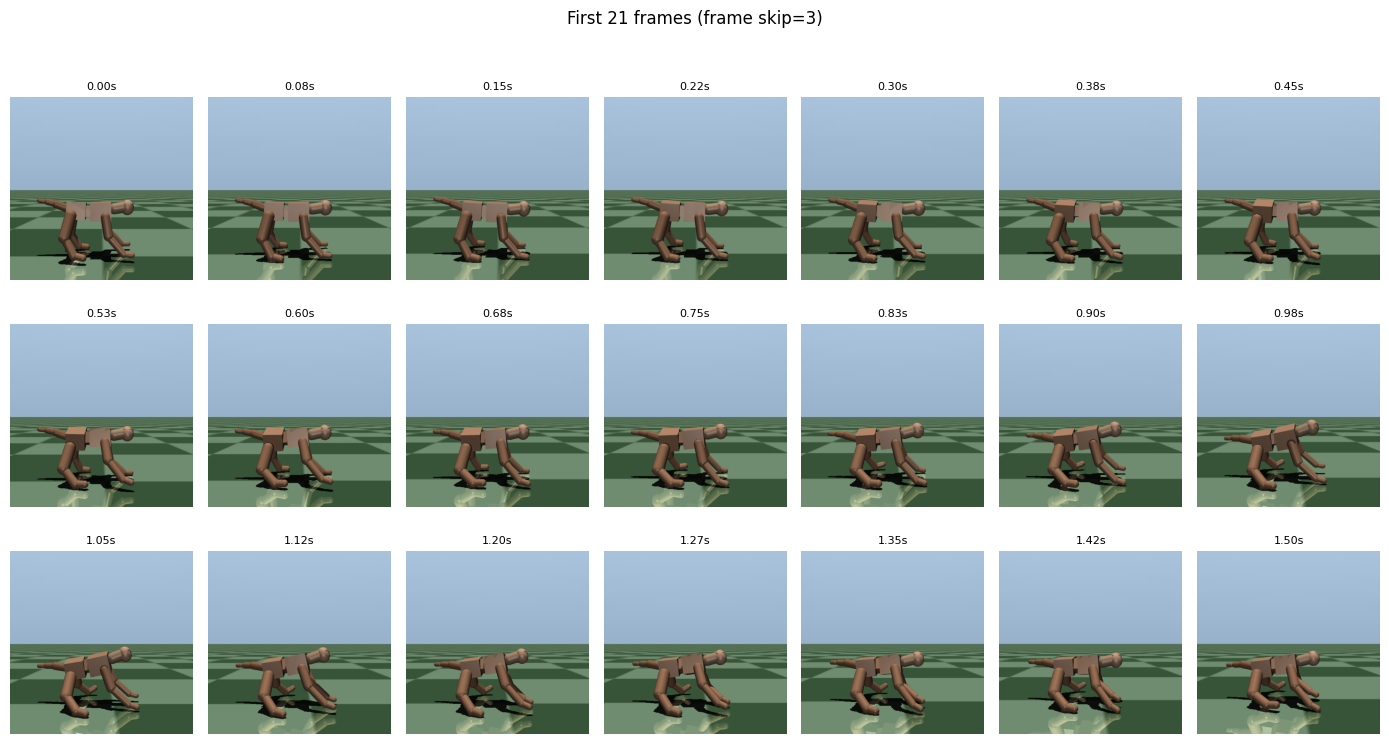

,time,chest_height,forward_velocity,height_reward,head_direction_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,0.075,0.194096,0.022398,1.368981,0.091882,1.048196,5.833054
2,0.150,0.192363,0.019833,1.308222,0.094239,1.030566,8.869937
3,0.225,0.191573,-0.031403,1.272830,0.094429,0.976813,9.760053
4,0.300,0.190876,-0.025295,1.245326,0.095374,-1.088317,8.623234
5,0.375,0.190813,0.030981,1.243477,0.096912,-1.038621,9.472240
6,0.450,0.190481,-0.057770,1.230505,0.097876,-1.070962,6.298824
7,0.525,0.187012,-0.131089,1.131587,0.098262,0.791225,4.788897
8,0.600,0.183367,-0.073717,1.052599,0.097971,0.679240,0.970068
9,0.675,0.179406,-0.022083,0.979203,0.099801,-1.381550,-1.104717


In [3]:
from src import render_model_gym
importlib.reload(lucy)
importlib.reload(render_model_gym)


def make_env(render_mode = 'None', *args, **kwargs):
     return lucy.LucyStandingWrapper(
        lucy.LucyEnv(xml_file=xml_path, render_mode=render_mode, max_episode_seconds = 5),
     )


df = render_model_gym.display_test_env(make_env(render_mode='rgb_array'), max_frames=21, frame_skip=3, attr_keys=["chest_height", "forward_velocity", "height_reward", "head_direction_reward"])
plt.show()
df

# Phase 1: Standing Training

First, train Lucy to stand upright in place without falling. This teaches:
- Balance and stability
- Appropriate joint positions for standing
- How to use tail and limbs for balance

In [4]:
standing_vec_env = make_vec_env(
    make_env,
    n_envs=n_envs,
    vec_env_cls=SubprocVecEnv,
    monitor_dir=log_dir,
)
standing_vec_env = VecMonitor(standing_vec_env, log_dir)

print(f"Created {n_envs} parallel standing environments")
print(f"Logging to: {log_dir}")


standing_model = PPO(
    "MlpPolicy",
    standing_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=256,
    n_epochs=5,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,  # Encourage exploration
    learning_rate=4e-4,
    policy_kwargs=dict(
        net_arch=dict(pi=[512, 512], vf=[512, 512])  # Larger network for complex body
    ),
)

# Train for standing (shorter since simpler task)
STANDING_TIMESTEPS = 800_000
print(f"Training standing policy for {STANDING_TIMESTEPS:,} timesteps...")
standing_model.learn(total_timesteps=STANDING_TIMESTEPS)

c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Created 7 parallel standing environments
Logging to: logs/lucy_standing_2026-01-09_22-32/
Using cpu device
Training standing policy for 800,000 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 65.2     |
|    ep_rew_mean     | -43.8    |
| time/              |          |
|    fps             | 2461     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 70.8        |
|    ep_rew_mean          | -4.89       |
| time/                   |             |
|    fps                  | 2241        |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.018992769 |
|    clip_fraction        | 0.289       |

In [5]:
standing_model_save_path = os.path.join(PROJECT_ROOT, "trained_models", f"lucy_standing_model_{sim_start_time}")
standing_model.save(standing_model_save_path)

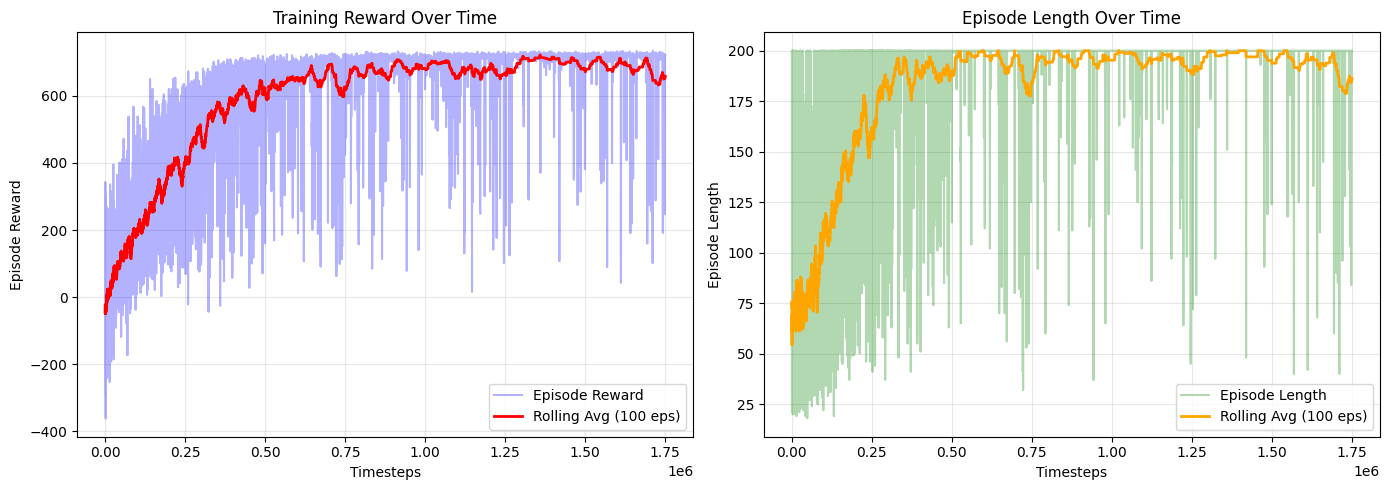

Training Summary:
Total episodes: 10824
Final avg reward (last 100 eps): 657.99
Max reward: 734.38
  Final avg length (last 100 eps): 186.2


In [6]:


standing_df = load_results(log_dir)
helpers.plot_training_progress(standing_df)
helpers.print_training_summary(standing_df)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


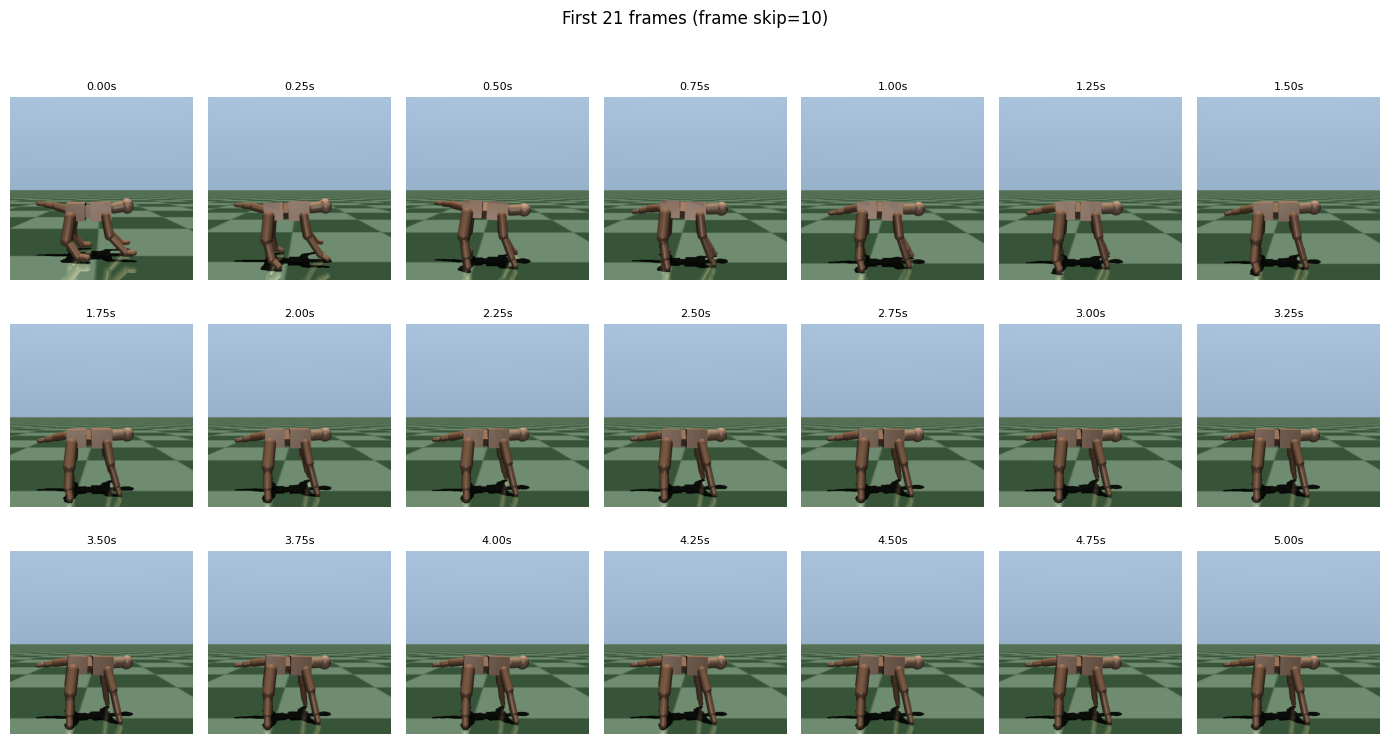

,time,chest_height,forward_velocity,height_reward,head_direction_reward,reward,cum_reward
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,0.25,0.226545,0.208197,2.0,0.096367,3.679011,27.591457
2,0.50,0.229199,-0.008629,2.0,0.096508,3.703520,64.146756
3,0.75,0.231469,0.053799,2.0,0.093600,3.697450,101.266511
4,1.00,0.235243,0.016808,2.0,0.092906,3.735526,138.499849
5,1.25,0.234986,-0.001778,2.0,0.089219,3.741047,175.934353
6,1.50,0.235029,-0.005326,2.0,0.089229,3.760448,213.447133
7,1.75,0.235183,0.000411,2.0,0.087666,3.762264,251.167740
8,2.00,0.234378,-0.001802,2.0,0.082928,3.744392,288.668623
9,2.25,0.233140,-0.006984,2.0,0.078305,3.752179,326.130377


In [7]:
model = PPO.load(standing_model_save_path, env =make_env())
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=[
        "chest_height",
        "forward_velocity",
        "height_reward",
        "head_direction_reward",
    ],
    model=model,
)
plt.show()
display(df)

In [8]:
#render_model_gym.render_model_gym(standing_model_path, xml_path)

# Phase 2: Walking Training (Transfer Learning)

Now train Lucy to walk forward, starting from the standing policy.
This transfer learning approach:
1. Starts with a policy that already knows how to balance
2. Fine-tunes to add forward motion while maintaining stability

- **trained_models\lucy_walking_model_2026-01-09_23-44.zip** somewhat walks. It uses two of its arms to support itself and can progress forward. I will need to further improve its definitions to achieve wanted results.

<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
C:\Users\326po\AppData\Local\Temp\ipykernel_28876\4124575433.py:29: SyntaxWarning: invalid escape sequence '\l'
  load_standing_model_path = "trained_models\lucy_standing_model_2026-01-09_22-32.zip"


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


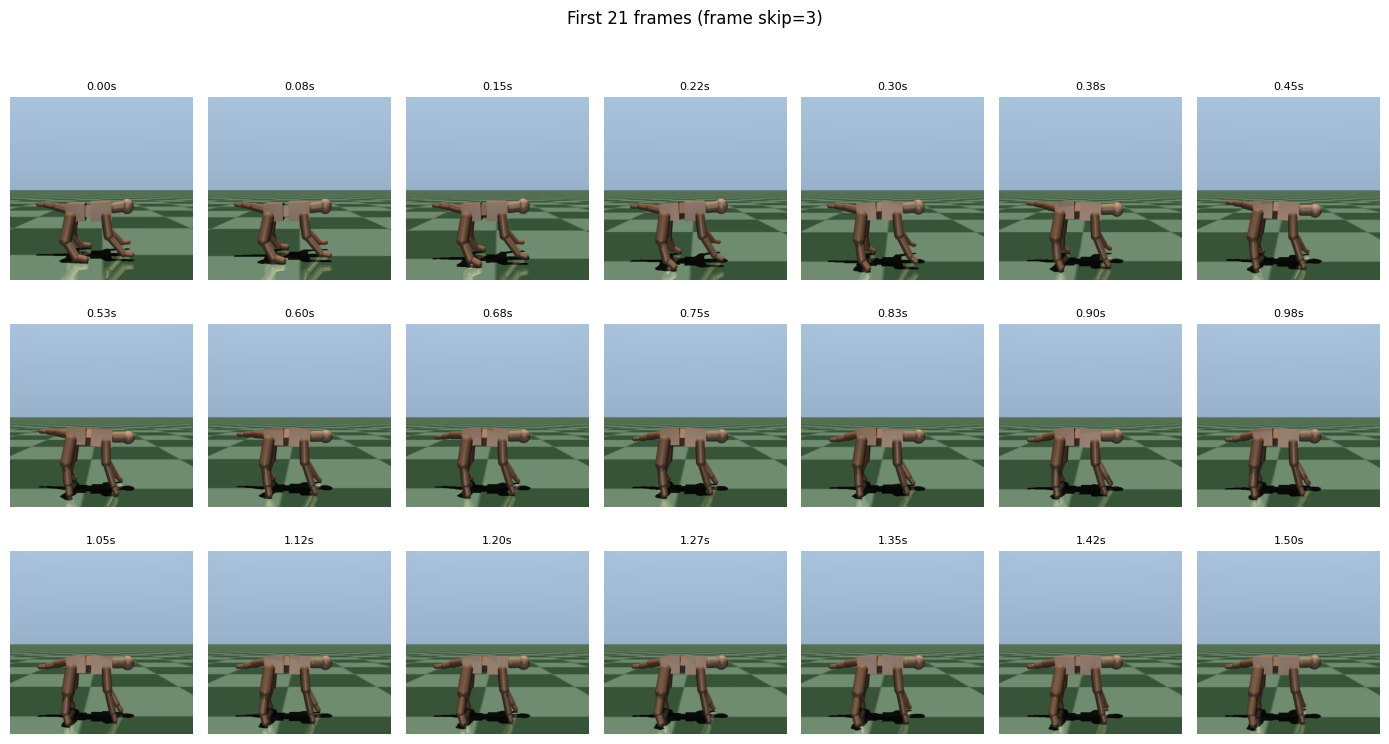

,time,gait_reward,ctrl_cost,forward_reward,standing_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,0.075,0.0,0.002544,0.033696,0.357915,0.889067,1.810302
2,0.150,0.0,0.002059,0.076587,0.357875,0.932403,4.564759
3,0.225,0.0,0.001753,0.092266,0.357875,0.948388,7.397533
4,0.300,0.0,0.003238,0.120962,0.357486,0.975210,10.287922
5,0.375,0.0,0.001866,0.165492,0.357640,1.021266,13.298086
6,0.450,0.0,0.002054,0.065831,0.356940,0.920718,16.176706
7,0.525,0.0,0.001593,-0.026926,0.356225,0.827705,18.785826
8,0.600,0.0,0.001266,-0.073996,0.356657,0.781394,21.138881
9,0.675,0.0,0.001210,-0.003752,0.356690,0.851728,23.656199


In [3]:
# Create walking training environment
importlib.reload(lucy)


walking_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
walking_log_dir = f"logs/lucy_walking_{walking_start_time}/"
os.makedirs(walking_log_dir, exist_ok=True)


def make_walking_env(render_mode="None"):
    """Factory function for walking environment."""
    env = lucy.LucyEnv(
        xml_file=xml_path,
        render_mode=render_mode,
        max_episode_seconds=20,
    )
    env = lucy.LucyWalkingWrapper(
        env,
        height_weight=0.2,
        forward_weight=1.0,
        gait_weight=0.2,
        ctrl_cost_weight=0.001,
        body_contact_penalty=-2.0,
        target_velocity=2,
    )
    return env


load_standing_model_path = "trained_models\lucy_standing_model_2026-01-09_22-32.zip"

env = make_walking_env(render_mode="rgb_array")  # your factory
model = PPO.load(load_standing_model_path, env=env)  # or walking model path
model.set_env(env)  # attach env so model.predict works
df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=["gait_reward", "ctrl_cost", "forward_reward", "standing_reward"],
    model=model,
)
plt.show()
df

In [10]:
walking_vec_env = make_vec_env(
    make_walking_env,
    n_envs=n_envs,
    vec_env_cls=SubprocVecEnv,
    monitor_dir=walking_log_dir,
)
walking_vec_env = VecMonitor(walking_vec_env, walking_log_dir)


standing_model_save_path = "trained_models\ppo_lucy_standing_2026-01-09_21-52.zip"
walking_model = PPO.load(standing_model_save_path, env = walking_vec_env)   # start from standing model
walking_model.set_env(walking_vec_env)   # attach walking env


walking_model.learn(total_timesteps=5_000_000)

<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
C:\Users\326po\AppData\Local\Temp\ipykernel_28876\1329298287.py:10: SyntaxWarning: invalid escape sequence '\p'
  standing_model_save_path = "trained_models\ppo_lucy_standing_2026-01-09_21-52.zip"
c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 165      |
|    ep_rew_mean     | 106      |
| time/              |          |
|    fps             | 2417     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 174         |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 2083        |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.018548837 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -27.5       |
|    explained_variance   | 0.819       |
|    learning_rate        | 0.

In [11]:
walking_model_path = os.path.join(PROJECT_ROOT, "trained_models", f"lucy_walking_model_{walking_start_time}")
walking_model.save(walking_model_path)

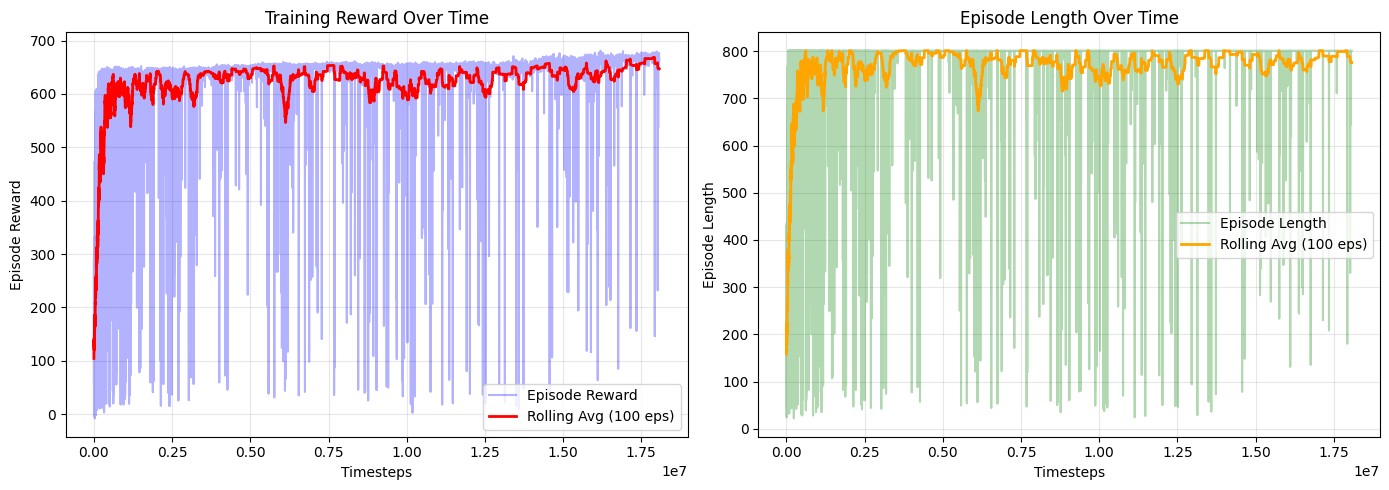

Training Summary:
Total episodes: 14460
Final avg reward (last 100 eps): 647.04
Max reward: 681.08
  Final avg length (last 100 eps): 775.9


In [12]:
# Plot walking training progress
walking_df = load_results(walking_log_dir)
helpers.plot_training_progress(walking_df)
helpers.print_training_summary(walking_df)

In [13]:
render_model_gym.render_model_gym(walking_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0250s per step
Running simulation at 1.0x speed... Close the window to exit.

Stopped by user
